## Predicting the 2018 FIFA World Cup Winner
In this Jupyter Notebook, we are going to develop a Machine Learning model to try to predict the outcomes of all games in World Cup 2018, which also means predicting the winner of the championship. 

We're going first to do some exploratory analysis on two datasets obtained from Kaggle. Then, we're going to do some feature engineering in order to select which features are the most relevant to the case in point, do some data manipulation, choose an ML model and finally deploy it on the dataset. Let's go!

### 1) Getting things ready
First step: import the necessary packages and read the files into pandas Dataframes. The first dataset `wc` features many lots of information on the teams participating in the tournament, while the second dataset `results` consists of a historical records of roughly all international matches played since... well, since the origins of football!

In [2]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Read data files
wc = pd.read_csv('data/World Cup 2018 Dataset.csv')
results = pd.read_csv('data/results.csv')

In [4]:
len(wc),len(results)

(33, 39082)

In [5]:
wc.head()

,Team,Group,Previous appearances,Previous titles,Previous finals,Previous semifinals,Current FIFA rank,First match against,Match index,history with first opponent W-L,history with first opponent goals,Second match against,Match index.1,history with second opponent W-L,history with second opponent goals,Third match against,Match index.2,history with third opponent W-L,history with third opponent goals,Unnamed: 19
0,Russia,A,10.0,0.0,0.0,1.0,65.0,Saudi Arabia,1.0,-1.0,-2.0,Egypt,17.0,NaN,NaN,Uruguay,33.0,0.0,0.0,NaN
1,Saudi Arabia,A,4.0,0.0,0.0,0.0,63.0,Russia,1.0,1.0,2.0,Uruguay,18.0,1.0,1.0,Egypt,34.0,-5.0,-5.0,NaN
2,Egypt,A,2.0,0.0,0.0,0.0,31.0,Uruguay,2.0,-1.0,-2.0,Russia,17.0,NaN,NaN,Saudi Arabia,34.0,5.0,5.0,NaN
3,Uruguay,A,12.0,2.0,2.0,5.0,21.0,Egypt,2.0,1.0,2.0,Saudi Arabia,18.0,-1.0,-1.0,Russia,33.0,0.0,0.0,NaN
4,Porugal,B,6.0,0.0,0.0,2.0,3.0,Spain,3.0,-12.0,-31.0,Morocco,19.0,-1.0,-2.0,Iran,35.0,2.0,5.0,NaN


In [6]:
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


### 2) Exploring the data
After taking a quick look at both datasets, I believe the `results` dataset is going to be more useful to our analysis, since we need data on past matches in order to predict future outcomes. It would be impossible to elaborate a model solely on the `wc` dataset.

We'll start by creating two auxiliary columns that will tell us the absolute **goal difference** in each match and the **outcome** of each match (that is, which team won, or whether the match ended in a tie). I believe these pieces of information should be useful when we arrive at the feature engineering discussion.

The Dataframe has an enormous amount of match records, but not all of them are actually useful for our analysis. We need to start thinking about which **features** exactly will be the most relevant for the ML model we are going to use. 

This is a very complex and time-consuming part of every Data Science project roadmap, so we are going to spend a good chunk of time here.

As you'll be able to see, I sometimes **pivot my analysis** because I realize some feature will not be as useful as I thought it would be. However, for documentation purposes, I left all steps of the exploratory analysis in this notebook.

In [7]:
# Adding new column for winner of each match
winner = []
for i in range(len(results['home_team'])):
    if results['home_score'][i] > results['away_score'][i]:
        winner.append(results['home_team'][i])
    elif results['home_score'][i] < results['away_score'][i]:
        winner.append(results['away_team'][i])
    else:
        winner.append('Tie')
results['winning_team'] = winner

# Adding new column for goal difference in matches
results['goal_difference'] = np.absolute(results['home_score'] - results['away_score'])

results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,winning_team,goal_difference
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,Tie,0
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,England,2
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,Scotland,1
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,Tie,0
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,Scotland,3


Let's work with a subset of the dataset: one that includes only games played by England. This will help us focus on what features would be interesting to observe for one country, and then we can later expand to all countries participating in the World Cup.

In [10]:
# Slice the dataset and create new 'england' Dataframe
df = results[(results['home_team'] == 'England') | (results['away_team'] == 'England')]
england = df.iloc[:]
england.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,winning_team,goal_difference
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,Tie,0
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,England,2
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,Scotland,1
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,Tie,0
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,Scotland,3


In [11]:
# Loop for creating a new column 'year'
year = []
for row in england['date']:
    year.append(int(row[:4]))
england['match_year'] = year

# Slicing the dataset to see how many matches took place from 1930 onwards (the year of the first ever World Cup)
england_1930 = england[england.match_year >= 1930]
england_1930.count()

date               810
home_team          810
away_team          810
home_score         810
away_score         810
tournament         810
city               810
country            810
winning_team       810
goal_difference    810
match_year         810
dtype: int64

Now let's try quickly visualizing the data to see which was the most common game outcome for England, and the distribution of games throughout the years.

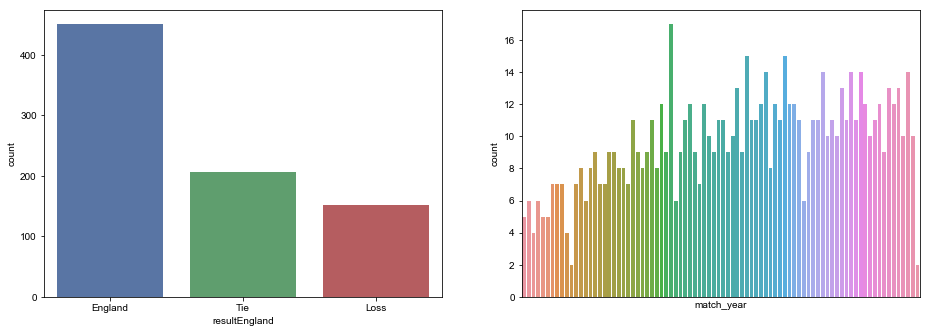

In [12]:
# Create auxiliary DataFrame for substituting other countries' names for 'Loss'
winrate = []
for row in england_1930['winning_team']:
    if row != 'England' and row != 'Tie':
        winrate.append('Loss')
    else:
        winrate.append(row)
dfwinrate = pd.DataFrame(winrate, columns=['resultEngland'])

# Plot with Seaborn and show
import matplotlib.ticker as ticker
import matplotlib.ticker as plticker

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15.7, 5.27)
sns.set(style="darkgrid")
sns.countplot(x='resultEngland', data=dfwinrate, ax = ax[0])
sns.countplot(x='match_year', data=england_1930, ax = ax[1])
plt.xticks(np.arange(min(england_1930.match_year), max(england_1930.match_year), 100))
plt.show()

Getting win rates for every country that will participate in the World Cup should be a useful information for our analysis. Maybe we can use these winning rates to predict the most likely outcomes of each match in the tournament?

However, there are many features in this dataset that won't help. The World Cup is always held in one place (in this year, Russia), so the location of previous matches won't add much to our analysis. The column 'tournament' will also be of little help, since all matches in which we are going to apply the model will be 'FIFA World Cup'. Thus, we can start defining more clearly our model's scope and limitations.

### 3) Defining the project

**Objective**: to create a Machine Learning model capable of predicting the outcomes of football games in the 2018 FIFA World Cup.

**Features**: Results of historical matches since the beginning of the championship (1930) for all participating teams.

**Limitations and obeservations**: I considered gathering data about the ranking of each team for all matches in the dataset; this way we would be able to see if the overall quality of the team impacted on the outcome of each match. However, the FIFA ranking was created only in the 90s, thus eliminating a huge portion of the dataset. I also searched for more ways to assess the quality of each team in each year, but such information was impossible to gather. A realiable proxy would be to average out the rating of each player in a team via their FIFA ratings (the game, not the organization). However, the game also started being realeased only in the 90s, turning this approach impossible. Therefore, for this project in particular, we will stick with historical match records to build a very simple model.

#### 3.1) Narrowing the 2018 World Cup participants

In [8]:
# Create a DF with all participating teams
wc_teams=["Uruguay",
"Russia",
"Spain", 
"Portugal",
"France",
"Denmark" ,
"Croatia" ,
"Argentina", 
"Brazil", 
"Switzerland",
"Sweden" ,
"Mexico", 
"Belgium" ,
"England", 
"Colombia", 
"Japan"]



# Filter the 'results' dataframe to show only teams in this years' world cup, from 1930 onwards
df_teams_home = results[results['home_team'].isin(wc_teams)]
df_teams_away = results[results['away_team'].isin(wc_teams)]
df_teams = pd.concat((df_teams_home, df_teams_away))
df_teams.drop_duplicates()
df_teams.count()


date               12068
home_team          12068
away_team          12068
home_score         12068
away_score         12068
tournament         12068
city               12068
country            12068
neutral            12068
winning_team       12068
goal_difference    12068
dtype: int64

In [9]:
df_teams.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,winning_team,goal_difference
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,England,2
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,Tie,0
6,1877-03-03,England,Scotland,1,3,Friendly,London,England,False,Scotland,2
10,1879-01-18,England,Wales,2,1,Friendly,London,England,False,England,1
11,1879-04-05,England,Scotland,5,4,Friendly,London,England,False,England,1


#### 3.2) Manipulating the data

Let's now slice the dataset to show only games from 1930 onwards. Football was probably a very different game before it started getting competitive with the introduction of the World Cup.

In [10]:
# Loop for creating a new column 'year'
year = []
for row in df_teams['date']:
    year.append(int(row[:4]))
df_teams['match_year'] = year

# Slicing the dataset to see how many matches took place from 1930 onwards (the year of the first ever World Cup)
df_teams30 = df_teams[df_teams.match_year >= 1930]
df_teams30.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,winning_team,goal_difference,match_year
1230,1930-01-01,Spain,Czechoslovakia,1,0,Friendly,Barcelona,Spain,False,Spain,1,1930
1231,1930-01-12,Portugal,Czechoslovakia,1,0,Friendly,Lisbon,Portugal,False,Portugal,1,1930
1237,1930-02-23,Portugal,France,2,0,Friendly,Porto,Portugal,False,Portugal,2,1930
1240,1930-03-23,France,Switzerland,3,3,Friendly,Colombes,France,False,Tie,0,1930
1241,1930-04-05,England,Scotland,5,2,British Championship,London,England,False,England,3,1930


All seems to be well. We have a dataset of a reasonable size to train our model. Now, let's drop all the columns we are not going to use (unfortunately, the majority of them). Essentially we will end up with a dataset which show the countries of each match and the outcome. Simple as that - let's see if it leads to something.

In [11]:
df_teams30 = df_teams30.drop(['date', 'tournament', 'city', 'country', 'goal_difference', 'match_year',"home_score",
                             "away_score"], axis=1)
df_teams30.head(5)

,home_team,away_team,neutral,winning_team
1230,Spain,Czechoslovakia,False,Spain
1231,Portugal,Czechoslovakia,False,Portugal
1237,Portugal,France,False,Portugal
1240,France,Switzerland,False,Tie
1241,England,Scotland,False,England


#### 3.3) Building the ML model

First, let's modify the "Y" (prediction label) in order to simplify our model's processing. The winning_team column will show "2" if the home team has won, "1" if it was a tie, and "0" if the away team has won.

In [12]:
df_teams30 = df_teams30.reset_index(drop=True)
df_teams30.loc[df_teams30.winning_team == df_teams30.home_team, 'winning_team']= 2
df_teams30.loc[df_teams30.winning_team == 'Tie', 'winning_team']= 1
df_teams30.loc[df_teams30.winning_team == df_teams30.away_team, 'winning_team']= 0

df_teams30.head()

,home_team,away_team,neutral,winning_team
0,Spain,Czechoslovakia,False,2
1,Portugal,Czechoslovakia,False,2
2,Portugal,France,False,2
3,France,Switzerland,False,1
4,England,Scotland,False,2


We will now set some dummies for the home_team and away_team variables, because otherwise we wouldn't be able to deploy a scikit-learn model on the dataset, since they are presented as categorical variables.

In [13]:
from sklearn.model_selection import train_test_split

# Get dummy variables
final = pd.get_dummies(df_teams30, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

# joining dummy with actual df 
#final = pd.concat([final,df_teams30.iloc[:,2:4]],axis=1)

In [14]:
# Separate X and y sets
X = final.drop(['winning_team'], axis=1)
y = final["winning_team"]
y = y.astype('int')

# Separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [15]:
X_train.shape,y_train.shape

((8874, 309), (8874,))

# Trying different models to check for better accuracy 

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [17]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True,degree=2),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(),
    MLPClassifier(hidden_layer_sizes=(20,10))]


log_cols = ["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)

acc_dict = {}

# Loop to do fit and predictions of each classifier into the dataset
for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    
    # Storing each score into a dict
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

# Storing the results in a DataFrame to be visualized
for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('Accuracy')
plt.title('Classifier Accuracy')

sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [18]:
# Because the Logistic regression is performing well so we are Choosing Logistic regression as our final model .
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
score = logreg.score(X_train, y_train)
score2 = logreg.score(X_test, y_test)

print("Training set accuracy: ", '%.3f'%(score))
print("Test set accuracy: ", '%.3f'%(score2))

Training set accuracy:  0.577
Test set accuracy:  0.558


For some incredible reason, the Logistic Regression we tried earlier remained the best model for predicting scores, even though its accuracy is still subpar. Let's stick with the model, then. Later, we could try thinking of ways to increase the model's accuracy, maybe by tuning some parameters, or using more sophisticated prediction models like neural networks. 

One important aspect when creating our prediction dataframe is how we will distribute the teams in the "home_team" column and the "away_team" column, since there are no "home" or "away" teams in World Cup games. So, let's first find out if there's in fact a bigger winrate for teams playing at home. Remember: 
"2" means home team win;
"1" means a tie;
"0" means away team win.

In [19]:
sns.countplot(x='winning_team', data=df_teams30)

There is, indeed, a bigger amount of wins for teams playing at home. Therefore, in the next section, we will use a very simplistic (but not too far-fetched) assumption for creating our predictions dataframe: the team which is positioned higher on the FIFA Ranking will be considered "favourite" for the match, and therefore, will be positioned under the "home_teams" column. You'll understand better below.

At last!

Now, let's start creating the necessary dataframe in which we'll deploy our model!
First, we'll start loading a dataset `ranking` containing FIFA rankings as of April 2018, and then a dataset `fixtures` containing the fixtures for the group stage of the championship.

After that, we'll do some quick data cleaning in order to fit our dataframe to the model's dimensional requirements and organize the teams in "home" and "away" teams according to their position in the FIFA rankings.

In [20]:
# Loading new datasets
ranking = pd.read_csv('https://raw.githubusercontent.com/brunoaks/FIFA-worldcup-2018-prediction/master/datasets/fifa_rankings.csv') # Obtained from https://us.soccerway.com/teams/rankings/fifa/?ICID=TN_03_05_01
fixtures = pd.read_csv('datasets/fixtures.csv')

#ranking = pd.read_csv('datasets/fifa_rankings.csv') # Obtained from https://us.soccerway.com/teams/rankings/fifa/?ICID=TN_03_05_01
#fixtures = pd.read_csv('datasets/fixtures.csv') # Obtained from https://fixturedownload.com/results/fifa-world-cup-2018

# List for storing the group stage games
pred_set = []

FileNotFoundError: File b'datasets/fixtures.csv' does not exist

In [ ]:
# Create new columns with ranking position of each team
fixtures.insert(1, 'first_position', fixtures['Home Team'].map(ranking.set_index('Team')['Position']))
fixtures.insert(2, 'second_position', fixtures['Away Team'].map(ranking.set_index('Team')['Position']))

# We only need the group stage games, so we have to slice the dataset
fixtures = fixtures.iloc[:48, :]
fixtures.tail()

In [46]:
# Loop to add teams to new prediction dataset based on the ranking position of each team
for index, row in fixtures.iterrows():
    if row['first_position'] < row['second_position']:
        pred_set.append({'home_team': row['Home Team'], 'away_team': row['Away Team'], 'winning_team': None})
    else:
        pred_set.append({'home_team': row['Away Team'], 'away_team': row['Home Team'], 'winning_team': None})
        
pred_set = pd.DataFrame(pred_set)
backup_pred_set = pred_set

pred_set.head()

,away_team,home_team,winning_team
0,Saudi Arabia,Russia,None
1,Egypt,Uruguay,None
2,Morocco,Iran,None
3,Spain,Portugal,None
4,Australia,France,None


Great! Now we already have a clean dataset with all group stage games for the FIFA World Cup 2018. Now we will just need to create some dummy variables, and then deploy an ML model into this DF. We can start by using our Logistic Regression Model.

In [ ]:
# Get dummy variables and drop winning_team column
pred_set = pd.get_dummies(pred_set, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

# Add missing columns compared to the model's training dataset
missing_cols = set(final.columns) - set(pred_set.columns)
for c in missing_cols:
    pred_set[c] = 0
pred_set = pred_set[final.columns]

# Remove winning team column
pred_set = pred_set.drop(['winning_team'], axis=1)

pred_set.head()

### 5) Deploying the model

At last, it's time to deploy our model and start predicting the matches away. Let's go!

In [ ]:
predictions = logreg.predict(pred_set)
for i in range(fixtures.shape[0]):
    print(backup_pred_set.iloc[i, 1] + " and " + backup_pred_set.iloc[i, 0])
    if predictions[i] == 2:
        print("Winner: " + backup_pred_set.iloc[i, 1])
    elif predictions[i] == 1:
        print("Tie")
    elif predictions[i] == 0:
        print("Winner: " + backup_pred_set.iloc[i, 0])
    print('Probability of ' + backup_pred_set.iloc[i, 1] + ' winning: ', '%.3f'%(logreg.predict_proba(pred_set)[i][2]))
    print('Probability of Tie: ', '%.3f'%(logreg.predict_proba(pred_set)[i][1]))
    print('Probability of ' + backup_pred_set.iloc[i, 0] + ' winning: ', '%.3f'%(logreg.predict_proba(pred_set)[i][0]))
    print("")


We'll have to separate the nations into 'home' teams and 'away' teams again. 

In [ ]:
# List of tuples before we arrange the teams in home and away
group_16 = [
            ("Uruguay", "Portugal"),
            ("France", "Argentina"),
            ("Brazil", "Mexico"),
            ("Belgium", "Japan"),
            ("Spain", "Russia"),
            ("Croatia", "Denmark"),
            ("Sweden", "Switzerland"),
            ("Colombia","England")]

In [ ]:
def clean_and_predict(matches, ranking, final, logreg):

    # Initialization of auxiliary list for data cleaning
    positions = []

    # Loop to retrieve each team's position according to FIFA ranking
    for match in matches:
        positions.append(ranking.loc[ranking['Team'] == match[0],'Position'].iloc[0])
        positions.append(ranking.loc[ranking['Team'] == match[1],'Position'].iloc[0])
    
    # Creating the DataFrame for prediction
    pred_set = []

    # Initializing iterators for while loop
    i = 0
    j = 0

    # 'i' will be the iterator for the 'positions' list, and 'j' for the list of matches (list of tuples)
    while i < len(positions):
        dict1 = {}

        # If position of first team is better, he will be the 'home' team, and vice-versa
        if positions[i] < positions[i + 1]:
            dict1.update({'home_team': matches[j][0], 'away_team': matches[j][1]})
        else:
            dict1.update({'home_team': matches[j][1], 'away_team': matches[j][0]})

        # Append updated dictionary to the list, that will later be converted into a DataFrame
        pred_set.append(dict1)
        i += 2
        j += 1

    # Convert list into DataFrame
    pred_set = pd.DataFrame(pred_set)
    backup_pred_set = pred_set

    # Get dummy variables and drop winning_team column
    pred_set = pd.get_dummies(pred_set, prefix=['home_team', 'away_team'], columns=['home_team', 'away_team'])

    # Add missing columns compared to the model's training dataset
    missing_cols2 = set(final.columns) - set(pred_set.columns)
    for c in missing_cols2:
        pred_set[c] = 0
    pred_set = pred_set[final.columns]

    # Remove winning team column
    pred_set = pred_set.drop(['winning_team'], axis=1)

    # Predict!
    predictions = logreg.predict(pred_set)
    for i in range(len(pred_set)):
        print(backup_pred_set.iloc[i, 1] + " and " + backup_pred_set.iloc[i, 0])
        if predictions[i] == 2:
            print("Winner: " + backup_pred_set.iloc[i, 1])
        elif predictions[i] == 1:
            print("Tie")
        elif predictions[i] == 0:
            print("Winner: " + backup_pred_set.iloc[i, 0])
        print('Probability of ' + backup_pred_set.iloc[i, 1] + ' winning: ' , '%.3f'%(logreg.predict_proba(pred_set)[i][2]))
        print('Probability of Tie: ', '%.3f'%(logreg.predict_proba(pred_set)[i][1])) 
        print('Probability of ' + backup_pred_set.iloc[i, 0] + ' winning: ', '%.3f'%(logreg.predict_proba(pred_set)[i][0]))
        print("")

In [51]:
clean_and_predict(group_16, ranking, final, logreg)

Portugal and Uruguay
Winner: Portugal
Probability of Portugal winning:  0.478
Probability of Tie:  0.265
Probability of Uruguay winning:  0.257

Argentina and France
Winner: Argentina
Probability of Argentina winning:  0.612
Probability of Tie:  0.193
Probability of France winning:  0.195

Brazil and Mexico
Winner: Brazil
Probability of Brazil winning:  0.704
Probability of Tie:  0.192
Probability of Mexico winning:  0.104

Belgium and Japan
Winner: Belgium
Probability of Belgium winning:  0.533
Probability of Tie:  0.206
Probability of Japan winning:  0.261

Spain and Russia
Winner: Spain
Probability of Spain winning:  0.496
Probability of Tie:  0.272
Probability of Russia winning:  0.232

Denmark and Croatia
Winner: Croatia
Probability of Denmark winning:  0.326
Probability of Tie:  0.254
Probability of Croatia winning:  0.419

Switzerland and Sweden
Winner: Sweden
Probability of Switzerland winning:  0.369
Probability of Tie:  0.250
Probability of Sweden winning:  0.381

England and

In [52]:
# List of matches
quarters = [('Brazil', 'Belgium'),
            ('Portugal', 'Argentina'),
            ('Croatia', 'Spain'),
            ('Sweden', 'England')]

In [53]:
clean_and_predict(quarters, ranking, final, logreg)

Brazil and Belgium
Winner: Brazil
Probability of Brazil winning:  0.723
Probability of Tie:  0.182
Probability of Belgium winning:  0.095

Portugal and Argentina
Winner: Portugal
Probability of Portugal winning:  0.356
Probability of Tie:  0.303
Probability of Argentina winning:  0.341

Spain and Croatia
Winner: Spain
Probability of Spain winning:  0.543
Probability of Tie:  0.244
Probability of Croatia winning:  0.213

England and Sweden
Winner: England
Probability of England winning:  0.556
Probability of Tie:  0.263
Probability of Sweden winning:  0.181



In [54]:
# List of matches
semi = [('Spain', 'England'),
        ('Brazil', 'Portugal')]

In [55]:
clean_and_predict(semi, ranking, final, logreg)

Spain and England
Winner: Spain
Probability of Spain winning:  0.429
Probability of Tie:  0.275
Probability of England winning:  0.296

Brazil and Portugal
Winner: Brazil
Probability of Brazil winning:  0.725
Probability of Tie:  0.144
Probability of Portugal winning:  0.132



All right, time for the big game!

Being Brazilian, and not having exactly forgotten about our last encounter with the Germans in the 2014 World Cup, I would be quite excited to see such a finale.

In [56]:
# The big game
finals = [('Spain', 'Brazil')]

In [57]:
clean_and_predict(finals, ranking, final, logreg)

Brazil and Spain
Winner: Brazil
Probability of Brazil winning:  0.570
Probability of Tie:  0.216
Probability of Spain winning:  0.215



According to the model winner is Brazil